<a href="https://colab.research.google.com/github/nebilarega/some-ml-projects/blob/main/face_recog_vgg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition using vggface2

## before face recognition first we should complete face detection using mtcnn ( Multi-task cascaded conv neural network

In [ ]:
# Install third tensorflow implementation of MTCNN
!pip install mtcnn

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mtcnn import MTCNN

In [ ]:
def detected_faces(image_path):
  image = plt.imread(image_path)
  detector = MTCNN()
  results = detector.detect_faces(image)
  bounding_boxes = []
  detected_face_images = []
  for i in range(len(results)):
    bounding_boxes.append(results[i]['box'])
    detected_face_images.append(
        image[bounding_boxes[i][1]: bounding_boxes[i][1]+bounding_boxes[i][3],
              bounding_boxes[i][0]: bounding_boxes[i][0]+bounding_boxes[i][2],
              ]
    )
    # return the detected faces and their corresponding bounding boxed
  return bounding_boxes, detected_face_images

In [ ]:
!pip install keras_applications

In [ ]:
import keras_vggface
print(keras_vggface.__version__)

0.6


In [ ]:
X_train = []
X_train.append(resize(detected_faces('/content/img1.jpg')[1][0], (224,224,3)))
X_train.append(resize(detected_faces('/content/img2.jpg')[1][0], (224,224,3)))
X_train.append(resize(detected_faces('/content/img3.jpg')[1][0], (224,224,3)))
X_train.append(resize(detected_faces('/content/img4.jpg')[1][0], (224,224,3)))

y_train = [0,0,1,1]

augmentation = ImageDataGenerator(
  rotation_range=20,
  zoom_range=0.15,
	width_shift_range=0.2,
	horizontal_flip=True)
for i in range(4):
  for j in range(64):
    X_train.append(np.reshape(augmentation.flow(np.reshape(X_train[i],(-1,224,224,3)), batch_size=1)[0], (224,224,3)))
    if i==0 | i==1:
      y_train.append(0)
    else:
      y_train.append(1)


In [ ]:
X_train = np.asarray(X_train)
y_train = np.array(y_train)

shuffle_index = np.random.permutation(260)
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

In [ ]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

vggface1 = VGGFace(model='vgg16')
vggface2 = VGGFace(model='resnet50')
vggface3 = VGGFace(model='senet50')

last_layer = vggface1.get_layer('pool5').output
x = tf.keras.layers.Flatten()(last_layer)
x = tf.keras.layers.Dense(512, activation='relu')(x)
out = tf.keras.layers.Dense(1, activation='softmax')(x)


model = tf.keras.Model(vggface1.input, out)

loss_fn = tf.keras.losses.BinaryCrossentropy()
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = tf.keras.metrics.BinaryAccuracy()

In [ ]:
model.compile(optimizer=optim, metrics=metrics, loss=loss_fn)

In [ ]:
model.fit(X_train, y_train, batch_size=10, epochs=4)

Epoch 1/4
26/26 [==============================] - 300s 12s/step - loss: 1.5631 - binary_accuracy: 0.7479
Epoch 2/4
26/26 [==============================] - 298s 11s/step - loss: 0.7464 - binary_accuracy: 0.7475
Epoch 3/4
26/26 [==============================] - 299s 11s/step - loss: 0.5179 - binary_accuracy: 0.7878
Epoch 4/4
26/26 [==============================] - 298s 11s/step - loss: 0.5445 - binary_accuracy: 0.7269


In [ ]:
def get_encodings(image_path):
  image = detected_faces(image_path)[1][0]
  x = np.reshape(resize(image, (224, 224, 3)), (-1,224,224,3))
  x = utils.preprocess_input(x, version=1)
  plt.imshow(image)
  plt.show()
  pred = model.predict(x)
  print(pred)
  return pred

In [ ]:
from scipy.spatial.distance import cosine

def is_match(encoding1, encoding2, threshold):
  score = cosine(encoding1,encoding2)
  if score <= threshold:
    print('it is a match')
  else:
    print('it is *NOT* a match')
  return score

In [ ]:
encoding1 = get_encodings('/content/img4.jpg')
encoding2 = get_encodings('/content/img6.jpg')

is_match(encoding1, encoding2, 0.6)

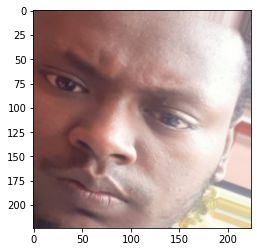

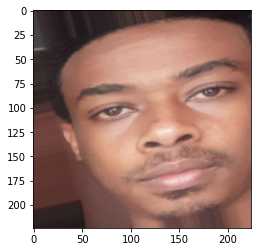

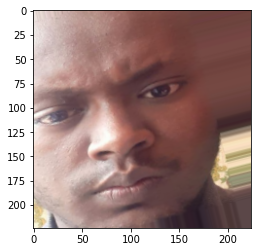

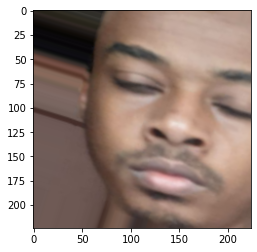

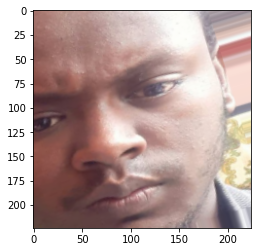

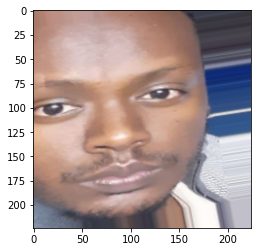

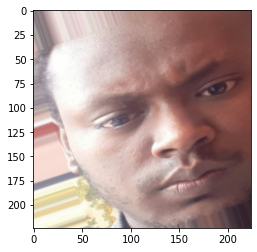

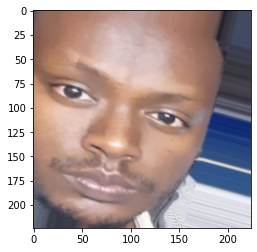

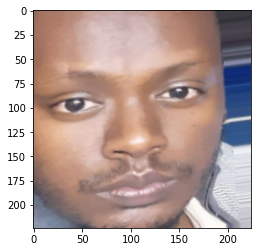

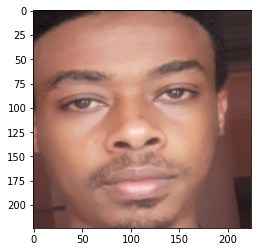

In [ ]:
for i in range(10):
  plt.imshow(X_train[i])
  plt.show()